In [1]:
#pandas - they standard data manipulation package
import pandas as pd
#numpy - scientific computation - matrix operations, etc.
import numpy as np
#for feature selection
from sklearn import feature_selection

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

In [2]:
####Part I - exploratory data analysis and feature engineering


#In this section, we explore the dataset, look for issues with the data and develop ideas for features we can build

#The column descriptions can be found in the "HomeCredit_columns_description". As you are going through this exercise,
#refer to the file to improve your understanding of the data as you progress


In [3]:
#We start with reading in the main training dataset, the dataset of applications; this has our target (default / non-default),
#as well as a bunch of other data that is very handy

#Here and below we do most our data manipulation using the "pandas" library, aliased as "pd". Pandas can be handy for quick
#  data manipulation in Python, but for heavier duty tasks different data manipulation tools are advisable (such as a relation
#  database, Spark for big data or newer tools like DataBricks)

train = pd.read_csv('application_train.csv')

#Think ahead: can you think of any issues we may encounter by pre-splitting our data into train and test in the beginning?
#   Think about advantages and disadvantages of this approach now and after you finish going through the exercise

In [4]:
#The next section focusing on EDA (Exploratory Data Analysis). Focus on understanding the data, identifying any possible issues
#   For best results, iterate between "asking questions" of the data by writing queries and tests as below, and outside knowledge
#   such as consulting the associated data dictionary and doing research on the business problem and associated business model

In [5]:

# The following query checks for missing data by calculating the number of "Null" or missing records, and the % of missing records
# in the dataset. 
total_null = train.isnull().count()
percent = (train.isnull().sum()/train.isnull().count()*100)
missing_check  = pd.concat([total_null, percent], axis=1, keys=['Total Null', 'Percent']).sort_values(ascending = False, by = ['Percent'])
#Prints out top 10 columns with the most missing values
missing_check.head(10)

#Sanity check - does it make sense for these to be missing? Some people would exclude data in this stage - can you think of why
#   we are better off keeping the data even if a large % of the data is missing?

,Total Null,Percent
COMMONAREA_MEDI,307511,69.872297
COMMONAREA_AVG,307511,69.872297
COMMONAREA_MODE,307511,69.872297
NONLIVINGAPARTMENTS_MODE,307511,69.432963
NONLIVINGAPARTMENTS_AVG,307511,69.432963
NONLIVINGAPARTMENTS_MEDI,307511,69.432963
FONDKAPREMONT_MODE,307511,68.386172
LIVINGAPARTMENTS_MODE,307511,68.354953
LIVINGAPARTMENTS_AVG,307511,68.354953
LIVINGAPARTMENTS_MEDI,307511,68.354953


In [6]:
#Let's define a function for our data exploration - a KDE plot. More on KDE plots can be found at: 
#   https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.kde.html#:~:text=Generate%20Kernel%20Density%20Estimate%20plot,and%20includes%20automatic%20bandwidth%20determination.


def mmf_kde_plot (df, var_name):
    plt.figure(figsize = (12, 6))

    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')

    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend()

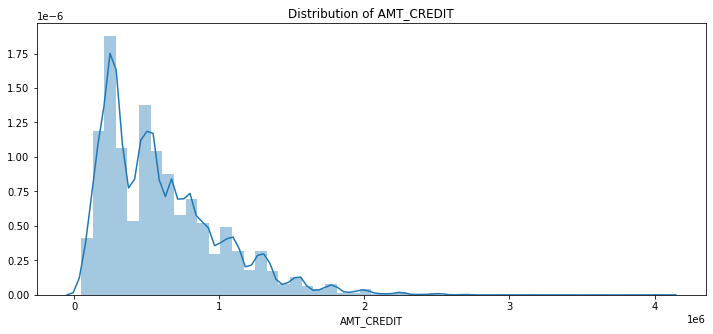

In [7]:
#Let's plot the distribution for the "Amount of credit column". Looks like this is bimodal - is this intuitive, or likely to 
#be an issue with the data or sampling?

plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_CREDIT")
ax = sns.distplot(train["AMT_CREDIT"])

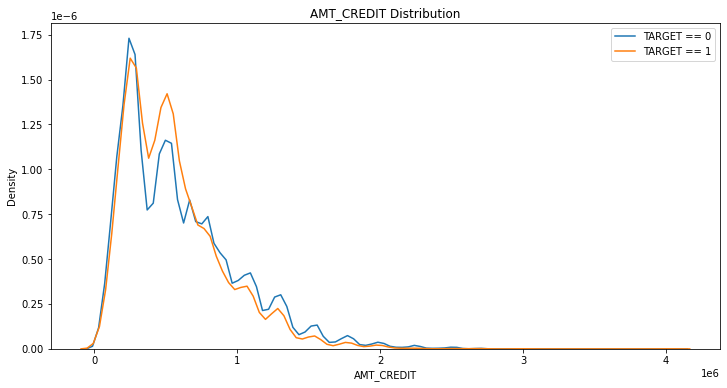

In [8]:
#A more interesting way to look at this data is to look for differences in the distribution between the defaults and non-defaults
#If the distributions are different, we can exploit these differences as features to make a better model

mmf_kde_plot(train, 'AMT_CREDIT')

In [9]:
#Distribution plots are not as nice for categorical variables in Python, but a simple table will do

def pop_rate (target):
    return target.sum() / target.count()


#Calculate the count and sum of our target variable, as well as the custom aggregate we defined above
train.groupby('NAME_TYPE_SUITE').agg({'TARGET': [pop_rate, 'count', 'sum']})

#High proportions in this chart mean high probabilities of default; as we can see, there is a bit of information in the suite
#type variable, but not a ton as the percentages are not very different

TARGET               
                 pop_rate   count    sum
NAME_TYPE_SUITE                         
Children         0.073768    3267    241
Family           0.074946   40149   3009
Group of people  0.084871     271     23
Other_A          0.087760     866     76
Other_B          0.098305    1770    174
Spouse, partner  0.078716   11370    895
Unaccompanied    0.081830  248526  20337

In [10]:
#In order to create better features, we should consider using other sources of data; let's pull in the cash balances dataset;

#Let's pull the credit card data in
cash_balance = pd.read_csv ('credit_card_balance.csv')

In [11]:
#Take a look at the dataset to get an understanding of what is in here; cross-reference this with the data dictionary

cash_balance.head(50)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.500,0.0,877.500,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.000,0.0,0.000,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.000,0.0,0.000,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.000,0.0,0.000,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.000,0.0,11547.000,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
5,2646502,380010,-7,82903.815,270000,0.0,0.000,0.0,0.000,4449.105,...,82773.315,82773.315,0.0,0,0.0,0.0,2.0,Active,7,0
6,1079071,171320,-6,353451.645,585000,67500.0,67500.000,0.0,0.000,14684.175,...,351881.145,351881.145,1.0,1,0.0,0.0,6.0,Active,0,0
7,2095912,118650,-7,47962.125,45000,45000.0,45000.000,0.0,0.000,0.000,...,47962.125,47962.125,1.0,1,0.0,0.0,51.0,Active,0,0
8,2181852,367360,-4,291543.075,292500,90000.0,289339.425,0.0,199339.425,130.500,...,286831.575,286831.575,3.0,8,0.0,5.0,3.0,Active,0,0
9,1235299,203885,-5,201261.195,225000,76500.0,111026.700,0.0,34526.700,6338.340,...,197224.695,197224.695,3.0,9,0.0,6.0,38.0,Active,0,0


In [12]:
#Part I of the MMF e-learning exercise:

#List out 20 ideas for features using the application, cash balance, or any other data source provided. 
#  Explain why this feature is impactful, and include code or pseudo-code to generate these features

In [13]:
#You can use these basic features as inspiration - these calculate the sum of the total balance for each application,
#as well as the sum filtered to the last 12 month, and the 12 month in the year preceding the application

#To calculate these; we first "group by" our data by the application ID SK_ID_CURR, and then aggregate the AMT_BALANCE column;
#   The last 2 features also add a column on the time column to only include data in the appropriate time slice in the aggregation
cash_balance_feats = cash_balance.groupby('SK_ID_CURR') \
  .apply(lambda x: pd.Series({
      'amt_balance': x['AMT_BALANCE'].sum(),
      'amt_balance_0_1_year': x['AMT_BALANCE'][x['MONTHS_BALANCE'] >= -12].sum(),
      'amt_balance_1_2_year': x['AMT_BALANCE'][(x['MONTHS_BALANCE'] < -12) & (x['MONTHS_BALANCE'] >= -24)].sum()
  })
)



In [14]:
#spot check our results
cash_balance_feats.head(n=20)

,amt_balance,amt_balance_0_1_year,amt_balance_1_2_year
SK_ID_CURR,,,
100006,0.000,0.000,0.000
100011,4031676.225,0.000,0.000
100013,1743352.245,0.000,0.000
100021,0.000,0.000,0.000
100023,0.000,0.000,0.000
100028,396167.850,131561.010,105494.670
100036,0.000,0.000,0.000
100042,2801919.375,0.000,0.000
100043,6882895.800,0.000,3293125.875


In [15]:
#After generating complex features like this, it is a good idea to spot check the calculations. You can copy this data to Excel
#to make sure the aggregations are done correctly

cash_balance.sort_values(by=['MONTHS_BALANCE'],ascending=False)[cash_balance['SK_ID_CURR']==100028]

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
617886,1914954,100028,-1,37335.915,225000,0.0,22823.550,0.0,22823.550,11250.000,...,36980.415,36980.415,0.0,4,0.0,4.0,35.0,Active,0,0
1660670,1914954,100028,-2,24710.085,225000,0.0,15009.615,0.0,15009.615,11250.000,...,24354.585,24354.585,0.0,9,0.0,9.0,34.0,Active,0,0
1835811,1914954,100028,-3,20221.830,225000,0.0,19867.500,0.0,19867.500,0.000,...,19866.330,19866.330,0.0,9,0.0,9.0,33.0,Active,0,0
1561465,1914954,100028,-4,0.000,225000,0.0,0.000,0.0,0.000,0.000,...,0.000,0.000,0.0,0,0.0,0.0,33.0,Active,0,0
1460388,1914954,100028,-5,0.000,225000,0.0,0.000,0.0,0.000,0.000,...,0.000,0.000,0.0,0,0.0,0.0,33.0,Active,0,0
1272681,1914954,100028,-6,0.000,225000,0.0,0.000,0.0,0.000,0.000,...,0.000,0.000,0.0,0,0.0,0.0,33.0,Active,0,0
1498585,1914954,100028,-7,0.000,225000,0.0,0.000,0.0,0.000,0.000,...,0.000,0.000,0.0,0,0.0,0.0,33.0,Active,0,0
1384907,1914954,100028,-8,0.000,225000,0.0,0.000,0.0,0.000,6438.330,...,0.000,0.000,0.0,0,0.0,0.0,33.0,Active,0,0
3060632,1914954,100028,-9,6438.330,225000,0.0,5996.835,0.0,5996.835,7855.110,...,6082.830,6082.830,0.0,3,0.0,3.0,32.0,Active,0,0
2466412,1914954,100028,-10,7888.545,225000,0.0,0.000,0.0,0.000,11250.000,...,7533.045,7533.045,0.0,0,0.0,0.0,31.0,Active,0,0


In [16]:
#look at aggregates - this is another way to check things are making sense, by doing a sniff-test from a higher level

cash_balance.describe()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
count,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,...,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,3.840312e+06,3.840312e+06
mean,1.904504e+06,2.783242e+05,-3.452192e+01,5.830016e+04,1.538080e+05,5.961325e+03,7.433388e+03,2.881696e+02,2.968805e+03,3.540204e+03,...,5.596588e+04,5.808881e+04,5.809829e+04,3.094490e-01,7.031439e-01,4.812496e-03,5.594791e-01,2.082508e+01,9.283667e+00,3.316220e-01
std,5.364695e+05,1.027045e+05,2.666775e+01,1.063070e+05,1.651457e+05,2.822569e+04,3.384608e+04,8.201989e+03,2.079689e+04,5.600154e+03,...,1.025336e+05,1.059654e+05,1.059718e+05,1.100401e+00,3.190347e+00,8.263861e-02,3.240649e+00,2.005149e+01,9.751570e+01,2.147923e+01
min,1.000018e+06,1.000060e+05,-9.600000e+01,-4.202502e+05,0.000000e+00,-6.827310e+03,-6.211620e+03,0.000000e+00,0.000000e+00,0.000000e+00,...,-4.233058e+05,-4.202502e+05,-4.202502e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434385e+06,1.895170e+05,-5.500000e+01,0.000000e+00,4.500000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00
50%,1.897122e+06,2.783960e+05,-2.800000e+01,0.000000e+00,1.125000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01,0.000000e+00,0.000000e+00
75%,2.369328e+06,3.675800e+05,-1.100000e+01,8.904669e+04,1.800000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.633911e+03,...,8.535924e+04,8.889949e+04,8.891451e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00
max,2.843496e+06,4.562500e+05,-1.000000e+00,1.505902e+06,1.350000e+06,2.115000e+06,2.287098e+06,1.529847e+06,2.239274e+06,2.028820e+05,...,1.472317e+06,1.493338e+06,1.493338e+06,5.100000e+01,1.650000e+02,1.200000e+01,1.650000e+02,1.200000e+02,3.260000e+03,3.260000e+03


In [17]:
#Now that we made these new features, we need to join them back to our initial dataset

train = train.merge(cash_balance_feats, on = 'SK_ID_CURR', how = 'left')


#And do a bit of cleanup - clean up missing values so that we can fix our random forest technique
for col_name in ['amt_balance', 'amt_balance_0_1_year', 'amt_balance_1_2_year']:
    train[col_name] = train[col_name].fillna(0)

# Spot check the resulting dataframe - scroll to the right for our new columns
train.head(25)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,amt_balance,amt_balance_0_1_year,amt_balance_1_2_year
0,100002,1,Cash loans,M,N,Y,0,202500.000,406597.5,24700.5,...,0,0.0,0.0,0.0,0.0,0.0,1.0,0.000,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.000,1293502.5,35698.5,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.000,135000.0,6750.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.000,312682.5,29686.5,...,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.000,513000.0,21865.5,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0
5,100008,0,Cash loans,M,N,Y,0,99000.000,490495.5,27517.5,...,0,0.0,0.0,0.0,0.0,1.0,1.0,0.000,0.0,0.0
6,100009,0,Cash loans,F,Y,Y,1,171000.000,1560726.0,41301.0,...,0,0.0,0.0,0.0,1.0,1.0,2.0,0.000,0.0,0.0
7,100010,0,Cash loans,M,Y,Y,0,360000.000,1530000.0,42075.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0
8,100011,0,Cash loans,F,N,Y,0,112500.000,1019610.0,33826.5,...,0,0.0,0.0,0.0,0.0,0.0,1.0,4031676.225,0.0,0.0
9,100012,0,Revolving loans,M,N,Y,0,135000.000,405000.0,20250.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.0,0.0


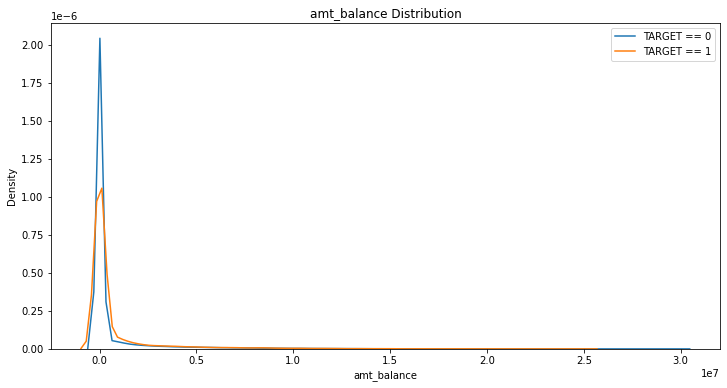

In [18]:
#Let's plot our new feature for defaults and non-defaults; does this like the feature is informative?

mmf_kde_plot(train, 'amt_balance')

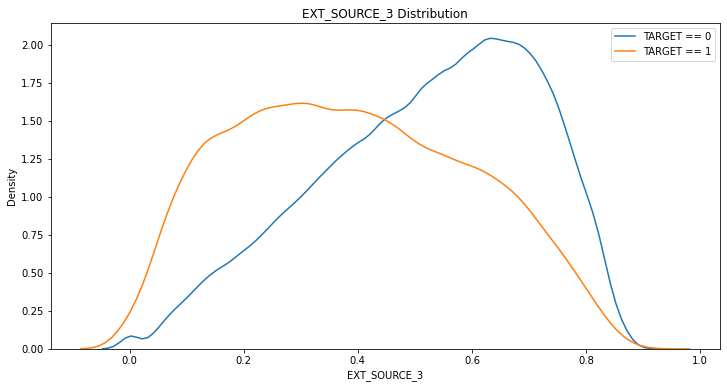

In [19]:
#Here is a similar plot for our best feature; notice how different the distributions are
#Refer to the data dictionary to understand why this feature might be so much better than any other

mmf_kde_plot(train, 'EXT_SOURCE_3')

In [20]:
#Now we need to do some more data manipulation to train our model - here we make dummy variables for our categorical data
#Recall this just turns them into a large number of columns with binary values

train_factorized = pd.get_dummies(train)


#let's pad the rest with 0's (for now)
#clean up infinite values also - just in case

train_factorized.replace([np.inf, -np.inf], np.nan)

for col in list(train_factorized.columns):
    train_factorized[col].fillna(0, inplace = True)
    



In [21]:
#Downsample our data (stratified) for speed; we filter out some of the negative labels, as defaults are rare
#and we are constrained by the number of defaults in our ability to train a model; generally filtering out
#part of the larger class does not casuse a significant hit to performance, but one needs to keep in mind
#when they change the class proportions when performing other analyses downstream

train_compute_mi_sample = train_factorized[train_factorized['TARGET'] ==1]
train_compute_mi_sample = train_compute_mi_sample.append(train_factorized[train_factorized['TARGET'] ==0].sample(frac = 0.1, replace = False))

#We sample for speed only - this is not strictly necessary, and may even hurt performance very slightly

In [22]:
#and QA!- make sure these counts are making sense

print(train_factorized.shape, train_compute_mi_sample.shape)

(307511, 249) (53094, 249)


In [23]:
#Exercise - make + explore more features

In [24]:
#train a baseline model

from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve,auc
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pylab as plt
import gc




In [25]:
#make our model object
#You can play around with these hyperparameters - these are set for speed; better performance can often be gained 
#By not limiting max-depth and allowing for split with a low number of samples

#all hyperparameters for the sklearn implementation of random forest can be found at 
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html


model = RandomForestClassifier(n_estimators=100, 
                               max_depth = 6, min_samples_split = 10)

Training Data Shape:  (53094, 247)


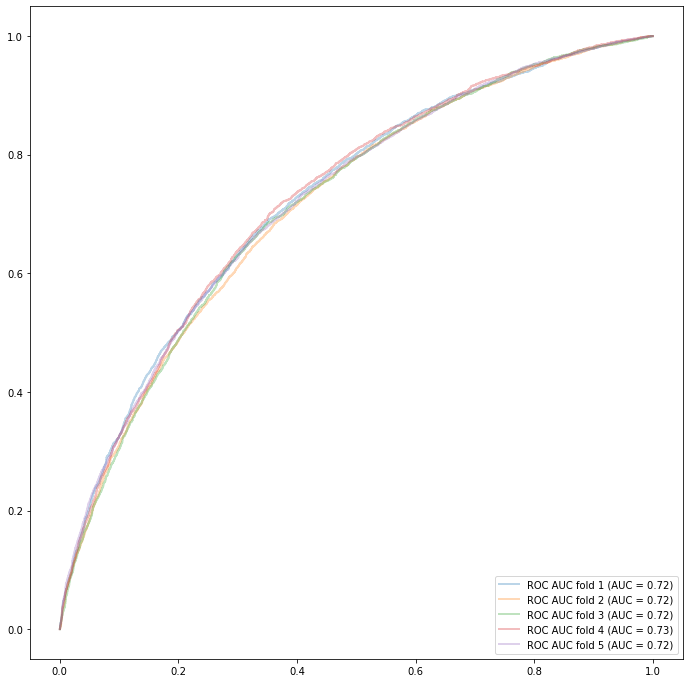

In [26]:
#do k-fold - find the best hyparparameters (change them above, e.g. max_depth, and see what version performs better)
#this process can be automated easily using :
#                https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html


# make plot
fig1 = plt.figure(figsize=[12,12])
ax1 = fig1.add_subplot(111,aspect = 'equal')

# Extract the ids
ids = train_compute_mi_sample['SK_ID_CURR']

# Extract the labels for training
labels = train_compute_mi_sample['TARGET']

#Drop the ID column and our target columns from the feater set (why?)
features = train_compute_mi_sample.drop(columns = ['SK_ID_CURR', 'TARGET'])

print('Training Data Shape: ', features.shape)

# Extract feature names - these will be used later to filter data and order columns correctly for our test set
feature_names = list(features.columns)

# Convert to np arrays - numpy arrays are what sklearn ultimately uses to build a model, though a pandas DataFrame can also
#   be supplied
training_matrix = np.array(features)

# Create the kfold object
k_fold = KFold(n_splits = 5, shuffle = True, random_state = 50)

#Make a list to keep track of AUC values for each curve for each fold
aucs = []


#fold counter
i=1

#This loops through our 5 folds, creates a model every time, and plots the associated AUC curve; you can iterate on this
#   to see if any extra features you make or changes to the model are making an improvement
for train,test in k_fold.split(features,labels):
    fold_model = model.fit(features.iloc[train],labels.iloc[train])
    prob = fold_model.predict_proba(features.iloc[test])[:,1]
    fpr, tpr, t = roc_curve(labels.iloc[test], prob)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC AUC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1
    
plt.legend(loc="lower right")
plt.show()

#Below are the plots of ROC AUC for each of the 5 training folds. Notice the consistency between them - this is a good sign

In [27]:
#After we find the best hyperparameters, let's fit the model on the full train set and check the performance on test

best_model = RandomForestClassifier(n_estimators=150, 
                               max_depth = 8, min_samples_split = 10)

best_model.fit (features, labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

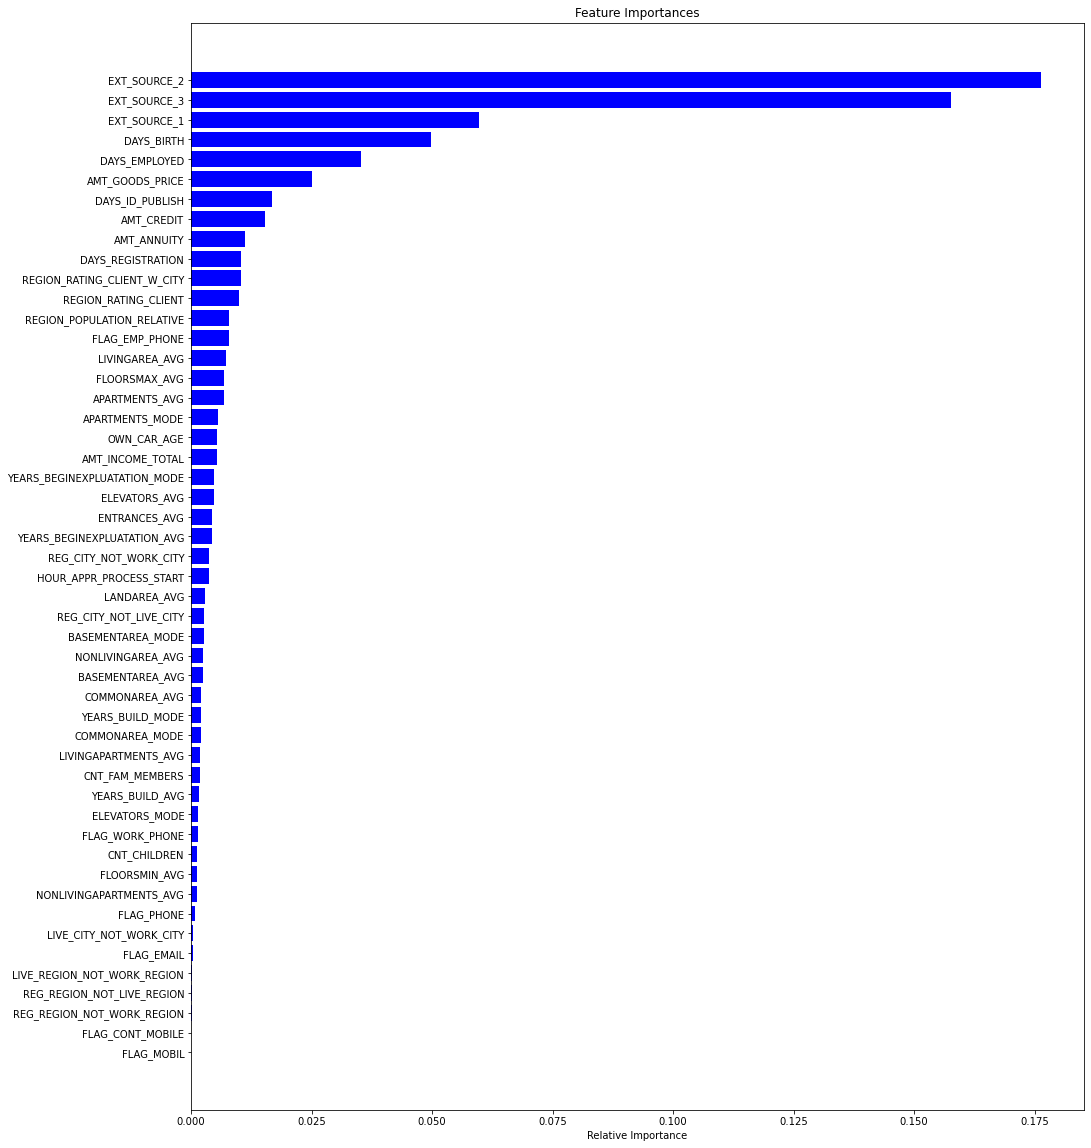

In [28]:
#Examine the best features (plot top 50 to avoid clutter)

importances = best_model.feature_importances_[0:50]
indices = np.argsort(importances)

plt.figure(figsize=(16, 20))

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#The base model is driven primarily by a handful of features; again, cross referencing with the data dictionary,
#do these make sense?

In [29]:
#Now we evaluate how the model performs

In [30]:
#We need to do the same feature engineering we did on train here - this is why splitting the two datasets is not convenient

#join our cash balance features

test_data = pd.read_csv('application_test.csv')

# Join to the training dataframe
test_data = test_data.merge(cash_balance_feats, on = 'SK_ID_CURR', how = 'left')

for col_name in ['amt_balance', 'amt_balance_0_1_year', 'amt_balance_1_2_year']:
    test_data[col_name] = test_data[col_name].fillna(0)

#factorize test df

test_factorized = pd.get_dummies(test_data)


#let's pad the rest with 0's (for now)
#clean up infinite values also - just in case

test_factorized.replace([np.inf, -np.inf], np.nan)

for col in list(test_factorized.columns):
    test_factorized[col].fillna(0, inplace = True)

In [31]:
#Note the order of our columns changed from train to test

In [32]:
for col in [col for col in train_factorized.columns if col not in test_factorized.columns]:
    print ('Adding column:', col)
    test_factorized[col] = 0

Adding column: CODE_GENDER_XNA
Adding column: NAME_INCOME_TYPE_Maternity leave
Adding column: NAME_FAMILY_STATUS_Unknown


In [33]:
test_features = test_factorized.drop(columns = ['SK_ID_CURR', 'TARGET'])

In [34]:
print (len(features.columns), len(test_features.columns))

247 250


In [39]:
#Finally, we make predictions using our best model, and save them to separate file

test_preds = best_model.predict_proba(test_features[features.columns])[:,1]
np.savetxt('test_preds.csv', test_preds, delimiter=',')

In [36]:
#Part 2 of the MMF e-Learning assignment: 

#Combine the predictions (test_preds) with the target column in the application_test file, and plot
#    charts of your choosing (PR, ROC AUC, etc.). Next, make any assumptions you need in order to create a profit curve 
#    (e.g. expected customer profitability, loss given default, etc.), and estimate the optimal probability cut-off to use for 
#    when this model is put in production

In [37]:
#Part 2.5 (optional, not marked): modify this notebook by adding additional features and using different hyperparameters or
#modeling approaches. Focus on cross-validation on train data, and don't worry about test if you choose to do this part of the
#exercise

In [38]:
#Part 3: in a 1-page write-up describe the steps you would take to improve this model, as well as what additional models 
#   can be built to improve the home credit risk business. For the additional models, describe how they can be integrated
#   with the strategy (i.e. how a score will be converted into an action), how they can be measured, and what some potential
#   risks or biases may be.